# A/B тестирование
Приоритизация гипотез и анализ результатов A/B теста.

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Загрузка файлов с данными и изучение общей информации.](#step_1)
* [2. Приоритизация](#step_2) 
* [3. Анализ  A/B-теста](#step_3) 
 * [3.01. График кумулятивной выручки по группам](#step_3.01)
 * [3.02. График кумулятивного среднего чека по группам](#step_3.02)
 * [3.03. График относительного изменения кумулятивного среднего чека группы B к группе A](#step_3.03)
 * [3.04. График кумулятивной конверсии по группам](#step_3.04)
 * [3.05. График относительного изменения кумулятивной конверсии группы B к группе A](#step_3.05)
 * [3.06. Точечный график количества заказов по пользователям](#step_3.06)
 * [3.07. 95-й и 99-й перцентили количества заказов на пользователя](#step_3.07)
 * [3.08. Точечный график стоимостей заказов](#step_3.08)
 * [3.09. 95-й и 99-й перцентили стоимости заказов](#step_3.09)
 * [3.10. Рассчет статистической значимости различий в конверсии между группами по «сырым» данным](#step_3.10)
 * [3.11. Рассчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#step_3.11)
 * [3.12. Рассчет статистической значимости различий в конверсии между группами по «очищенным» данным](#step_3.12)
 * [3.13. Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#step_3.13)
 * [3.14. Решение по результатам теста](#step_3.14)

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import numpy as np
import datetime as dt
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, e
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(15,5) # Зададим размер графиков по умолчанию

import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')


pd.set_option('max_columns', None) # Зададим вывод всех столбцов таблиц
pd.options.display.float_format = '{:.2f}'.format # Зададим удобный формат отображения вещественных чисел

In [2]:
# Универсальная функция если понадобится получить имя датафрейма или серии
def get_name(obj):
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

## 1. Загрузка данные и подготовка их к анализу  
[к оглавлению](#step_0)
<a class="anchor" id="step_1"></a>

In [3]:
# Загрузим датасеты
try:
    hypotheses = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')    
except:
    hypotheses = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/hypothesis.csv')
    orders = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/orders.csv')
    visitors = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/visitors.csv')

In [4]:
df_list = [hypotheses, orders, visitors]

In [5]:
for df in df_list:
    print(get_name(df))
    display(df.head())
    print(df.info())
    print('_' * 78)

hypotheses


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
______________________________________________________________________________
orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
______________________________________________________________________________
visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
______________________________________________________________________________


В исследуемых таблицах очевидно пропусков нет, но в тоблице hypotheses заголовки проименованы с заглавной буквы, а данные с датами представлены в строковом формате. Исправим это недоразумение, приведя даты к типу `datetime` а заголовки в удобный формат

In [6]:
for df in df_list:
    df.columns = [x.lower() for x in df.columns]
    for col in df.columns:
        if 'date' in col:
            df[col] = df[col].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
for df in df_list:
    print(get_name(df))
    display(df.head())
    print(df.info())
    print('_' * 90)

hypotheses


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
__________________________________________________________________________________________
orders


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
__________________________________________________________________________________________
visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
__________________________________________________________________________________________


In [8]:
for df in df_list:
    print(f'В датафрейме {get_name(df)} выявлено {df.duplicated().sum()} дубликатов')

В датафрейме hypotheses выявлено 0 дубликатов
В датафрейме orders выявлено 0 дубликатов
В датафрейме visitors выявлено 0 дубликатов


#### Вывод 
Таблицы загружены, типы данных приведены в соответствие содержимому. Пропусков и дубликатов нет. Приступим к нализу.

## 2. Приоритизация гипотез.
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

In [9]:
hypotheses['hypothesis'].unique()

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

In [10]:
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts']
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts']
hypotheses

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.00
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.00
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.20


In [11]:
hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


In [12]:
hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.00
2,Добавить блоки рекомендаций товаров на сайт ин...,56.00
0,"Добавить два новых канала привлечения трафика,...",40.00
6,Показать на главной странице баннеры с актуаль...,40.00
8,"Запустить акцию, дающую скидку на товар в день...",16.20
3,"Изменить структура категорий, что увеличит кон...",9.00
1,"Запустить собственную службу доставки, что сок...",4.00
5,"Добавить страницу отзывов клиентов о магазине,...",4.00
4,"Изменить цвет фона главной страницы, чтобы уве...",3.00


Рразница в методах ICE и RICE заключается в балансе критериев **impact** и **reach/impact**. Поскольку параметры **confidence** и **efforts** в двух методах одинаковы, в ICE решающую роль играет сила воздействия, в RICE - сила воздействия скорректированная на охват.  
#### **Иными словами ICE это стратегия, RICE это тактика**
_______________________________  
Например:  
* **"Запустить акцию, дающую скидку на товар в день рождения"** reach = 1, т.е. улучшение каснется минимального количества пользователей в течении какого-то периода с точки зрения RICE. В тоже время это улучшение повлияет на удовлетворенность клиентов в целом - у каждого ДР случается раз в 365 дней.   
* **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"** reach = 10, говорит о том что в процессе эксперимента или за период, например за 3 месяца, все увядят это изменение. В рамках RICE этот параметр выдвигает гипотезу на превое место, но в долгосрочной перспективе в рамках ICE, будет большой просев в 30% и нивелируя фактор охвата мы отодвигаем приоритет этой гипотезы на третье место.  
* **"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"** - reach = 3. Балл говорит сам за себя бизнес планирует охватить 30% аудитории, и это нововведение повлияет на эти 30% в полной мере, но с точки зрения ICE мы оцениваем эффект от процесса без корректировки на количество вовлеченных новых пользователей за некий период.    
* **"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"** Сила воздействия на пользователя оценена в 3 балла, причем охват - 5 говорят о так себе фиче, но поскольку мы на 8 баллов уверены в ее результативности оставляют эту гипотезу на 4 месте в приоритетах.  
* **"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"** и наконец в этой гипотезе параметр reach = 8 говорит не о внушительном охвате пользователей и в обозримом периоде RICE ставит приоритет гипотезы на второе место, но влияние - impact = 3 , оценивая гипотезу с точки зрения процесса, ICE отодвигает ее на пятое. В глобальном плане есть вопросы и посерьезней.  


## 3. Анализ A/B-теста  
[к оглавлению](#step_0)
<a class="anchor" id="step_3"></a>

### 3.01. График кумулятивной выручки по группам.  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.01"></a>

Сперва взглянем на простой график выручки по дням

In [13]:
both_groups = orders.groupby(['visitorid', 'group']).agg({'transactionid':'count'}).unstack().reset_index()
both_groups.columns = ['visitorid', 'A', 'B']
both_groups['both'] = both_groups['A'] == both_groups['B']
double_group_visitors = both_groups.query('both == True')['visitorid']

In [14]:
orders = orders.query('visitorid not in @double_group_visitors').copy()

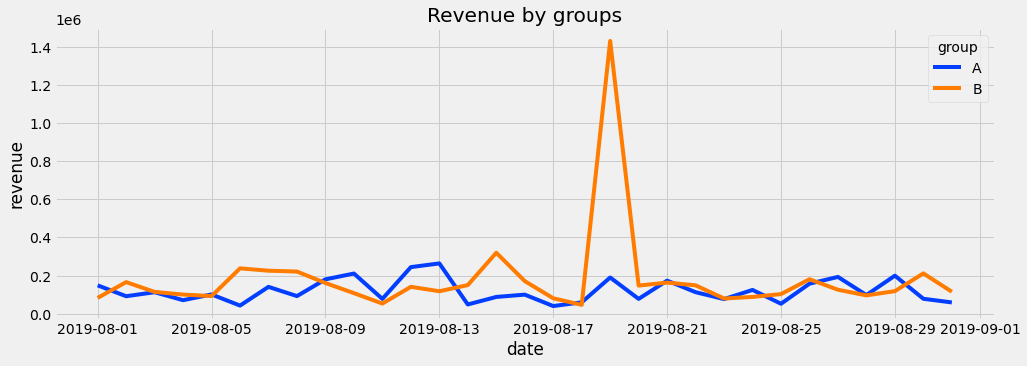

In [15]:
sns.lineplot(data=orders.groupby(['date', 'group']).agg({'revenue':'sum'}).reset_index(), 
             x='date', y='revenue', 
             hue='group', palette='bright', ci=None, estimator='sum')
plt.title('Revenue by groups')
plt.show()

На протяжении всего эксперимента в 1 месяц, кроме сильного скачка выручки в группе B 19 августа, на первый взляд две группы не особо отличаются. Определенных выводов сделать невозможно. Наглядней будет картинка, если мы выведем метрики накопительно

In [16]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [17]:
"""Код работает так: 
для каждой строки dates_groups проверяем равна ли группа и не больше ли дата из orders
и если условие выполняется, выводим: 
число уникальных пользователей, 
число уникальных заказов,
накопленную выручку"""
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date':'max', 
        'group':'max', 
        'transactionid':pd.Series.nunique, 
        'visitorid':pd.Series.nunique, 
        'revenue':'sum'}), axis=1).sort_values(by=['date','group']) 
orders_aggregated.tail()

,date,group,transactionid,visitorid,revenue
533,2019-08-29,B,565,513,5266434
757,2019-08-30,A,512,460,3643218
690,2019-08-30,B,587,534,5477657
958,2019-08-31,A,522,468,3702201
930,2019-08-31,B,605,551,5592646


In [18]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date':'max', 
        'group':'max', 
        'visitors':'sum'}), axis=1).sort_values(by=['date','group'])
visitors_aggregated.tail()

,date,group,visitors
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736
930,2019-08-31,B,18916


In [19]:
cumulative_data = pd.merge(orders_aggregated, visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.tail()

,date,group,orders,buyers,revenue,visitors
57,2019-08-29,B,565,513,5266434,17708
58,2019-08-30,A,512,460,3643218,18037
59,2019-08-30,B,587,534,5477657,18198
60,2019-08-31,A,522,468,3702201,18736
61,2019-08-31,B,605,551,5592646,18916


Для просмотра результата приемлемей выводить конец таблицы.  
Самое время построить графики кумулятивной выручки

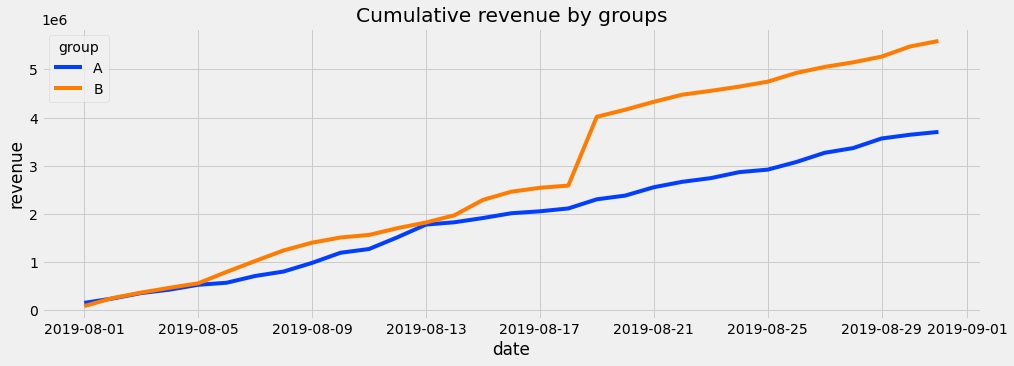

In [20]:
sns.lineplot(data=cumulative_data, x='date', y='revenue', hue='group', palette='bright', ci=None, estimator='sum')
plt.title('Cumulative revenue by groups')
plt.show()

Выручка в обеих группах растут практически из одной точки, но в группе B с 5.08 выручка начанает расти активнее. Впрочем 13.08 они снова пересекаются. Произошел едва заметный подскок в группе A и провал в группе B. Но начиная с 13.08 линии окончательно расходятся. Примерно 19.08 в группе B произошел резкий всплеск, который был заметен и на предыдущем графике. Наблюдаемый всплеск существенно отдалил линию B от A, но оставил линии параллельными. Однозначно это выброс. В ходе дальнейшего анализа пропробуем его нейтрализовать и посмотрим как повели бы себя графики без его участия. В любом случае, даже без всплеска видимая параллельность линий накопительной выручки мало очем говорит, т.к. выручка это метрика более высокого уровня. Понять причину событий поможет декомпозиция на более низкоуровневые метрики, типа число заказов, число клиентов, средний чек и т.п.

### 3.02. График кумулятивного среднего чека по группам. 
[к оглавлению](#step_0)
<a class="anchor" id="step_3.02"></a>

Средний чек (AOV — Average Order Value) — это отношение общей стоимости совершенных заказов (т.е. полученного дохода) к суммарному количеству заказов за определенный период. Измеряется в денежном эквиваленте.

In [21]:
cumulative_data['aov'] = cumulative_data['revenue'] / cumulative_data['orders']
cumulative_data.tail()

,date,group,orders,buyers,revenue,visitors,aov
57,2019-08-29,B,565,513,5266434,17708,9321.12
58,2019-08-30,A,512,460,3643218,18037,7115.66
59,2019-08-30,B,587,534,5477657,18198,9331.61
60,2019-08-31,A,522,468,3702201,18736,7092.34
61,2019-08-31,B,605,551,5592646,18916,9244.04


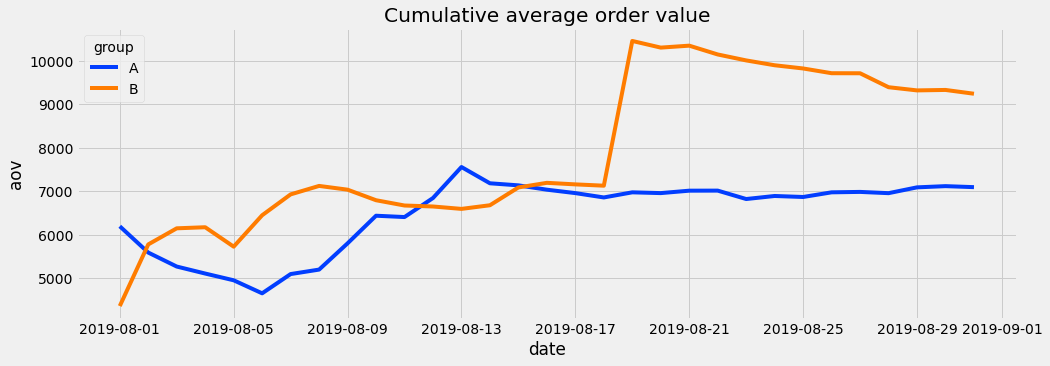

In [22]:
sns.lineplot(data=cumulative_data, x='date', y='aov', hue='group', palette='bright', ci=None, estimator='sum')
plt.title('Cumulative average order value')
plt.show()

Вычленив из выручки влияние среднего чека более заметно сближение (и даже прогиб) линии B 13.05. Похоже на выброс в группе A, им мы займемся позже. Так же заметна аномалия 19.08. Теперь мы знаем что причиной тому поскочивший средний чек. Впрочем дальнейшее направлении линии B направлено в сторону уменьшения, а линия A фиксируется на уровне 7000, даже с небольшим ростом. Продолжим наблюдения.

### 3.03. График относительного изменения кумулятивного среднего чека группы B к группе A.  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.03"></a>

Преобразуем таблицу в горизонтальное положение кумулятивных выручек и заказов, чтобы можно посчитать относительное изменение кумулятивного среднего чека. назовем эту метрику Relative Change of Average Order Value и расчитаем по формуле  

$$
rc\_{aov} = \frac{revenueB}{ordersB} : \frac{revenueA}{ordersA} - 1
$$

In [23]:
cumulative_data_horizont = cumulative_data.pivot_table(
    index='date', columns=['group'], values=['revenue', 'orders', 'visitors']).reset_index()
cumulative_data_horizont.columns = [''.join(col).strip() for col in cumulative_data_horizont.columns.values]
cumulative_data_horizont.tail()

,date,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB
26,2019-08-27,468,520,3267966,5052226,16376,16523
27,2019-08-28,484,548,3365628,5148234,16970,17177
28,2019-08-29,503,565,3565038,5266434,17547,17708
29,2019-08-30,512,587,3643218,5477657,18037,18198
30,2019-08-31,522,605,3702201,5592646,18736,18916


In [24]:
cumulative_data_horizont['rc_aov'] = (
    cumulative_data_horizont['revenueB'] / cumulative_data_horizont['ordersB']) / (
    cumulative_data_horizont['revenueA'] / cumulative_data_horizont['ordersA']) - 1
cumulative_data_horizont.tail()

,date,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB,rc_aov
26,2019-08-27,468,520,3267966,5052226,16376,16523,0.39
27,2019-08-28,484,548,3365628,5148234,16970,17177,0.35
28,2019-08-29,503,565,3565038,5266434,17547,17708,0.32
29,2019-08-30,512,587,3643218,5477657,18037,18198,0.31
30,2019-08-31,522,605,3702201,5592646,18736,18916,0.30


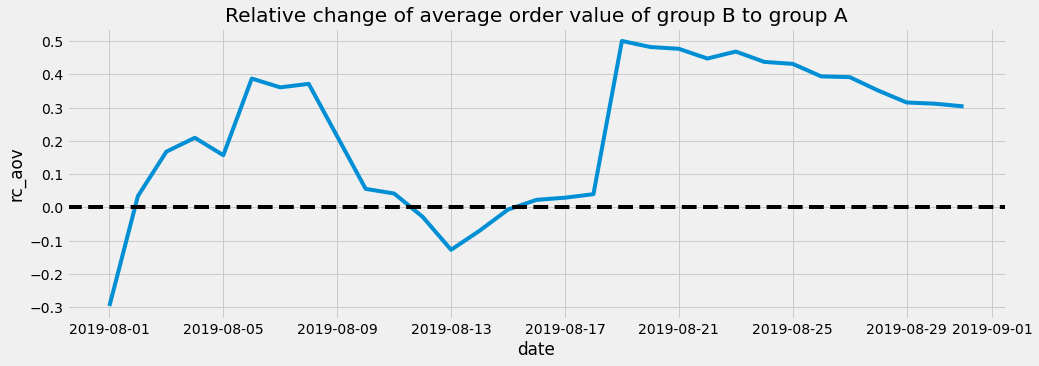

In [25]:
sns.lineplot(data=cumulative_data_horizont, x='date', y='rc_aov', palette='bright', ci=None, estimator='mean')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative change of average order value of group B to group A')
plt.show()

После относительно роста среднего чека группы B 6.08 и 7.08, 13.08 снова наблюдается провал и резкий подъем 19.08. Все эти выбросы в обеих группах заставляют скакать линию относительного изменения среднего чека вокруг нуля. Иначе при стабильном росте линия была бы параллельна пунктирной оси и располагалась сверху, в случае стабильного падения снизу, а без изменений слилась бы с ней. Займемся выбросами дальше.
<a class="anchor" id="step_8"></a> [обратно](#step_10)

### 3.04 График кумулятивной конверсии по группам. 
[к оглавлению](#step_0)
<a class="anchor" id="step_3.04"></a>

In [26]:
cumulative_data['cr'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.tail()

,date,group,orders,buyers,revenue,visitors,aov,cr
57,2019-08-29,B,565,513,5266434,17708,9321.12,0.03
58,2019-08-30,A,512,460,3643218,18037,7115.66,0.03
59,2019-08-30,B,587,534,5477657,18198,9331.61,0.03
60,2019-08-31,A,522,468,3702201,18736,7092.34,0.03
61,2019-08-31,B,605,551,5592646,18916,9244.04,0.03


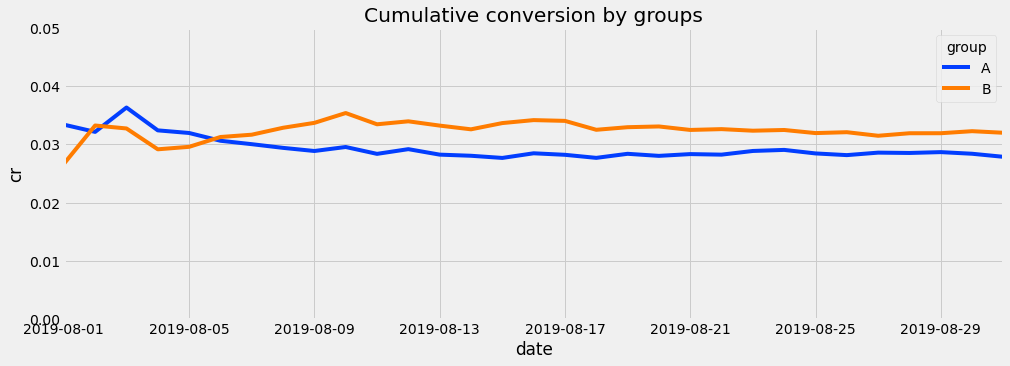

In [27]:
sns.lineplot(data=cumulative_data, x='date', y='cr', hue='group', palette='bright', ci=None, estimator='mean')
plt.axis([cumulative_data.date.min(),
          cumulative_data.date.max(), 0, 0.05])
plt.title('Cumulative conversion by groups')
plt.show()

Коневерсия группы B по началу несколько отстает от группы A, но после 10.08 устойчиво превышает и фиксируется на одном значении. Это значение определим в следующем пункте.

### 3.05. График относительного изменения кумулятивной конверсии группы B к группе A. 
[к оглавлению](#step_0)
<a class="anchor" id="step_3.05"></a>

In [28]:
cumulative_data_horizont['rc_cr'] = (
    cumulative_data_horizont['ordersB'] / cumulative_data_horizont['visitorsB']) / (
    cumulative_data_horizont['ordersA'] / cumulative_data_horizont['visitorsA']) - 1
cumulative_data_horizont.tail()

,date,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB,rc_aov,rc_cr
26,2019-08-27,468,520,3267966,5052226,16376,16523,0.39,0.10
27,2019-08-28,484,548,3365628,5148234,16970,17177,0.35,0.12
28,2019-08-29,503,565,3565038,5266434,17547,17708,0.32,0.11
29,2019-08-30,512,587,3643218,5477657,18037,18198,0.31,0.14
30,2019-08-31,522,605,3702201,5592646,18736,18916,0.30,0.15


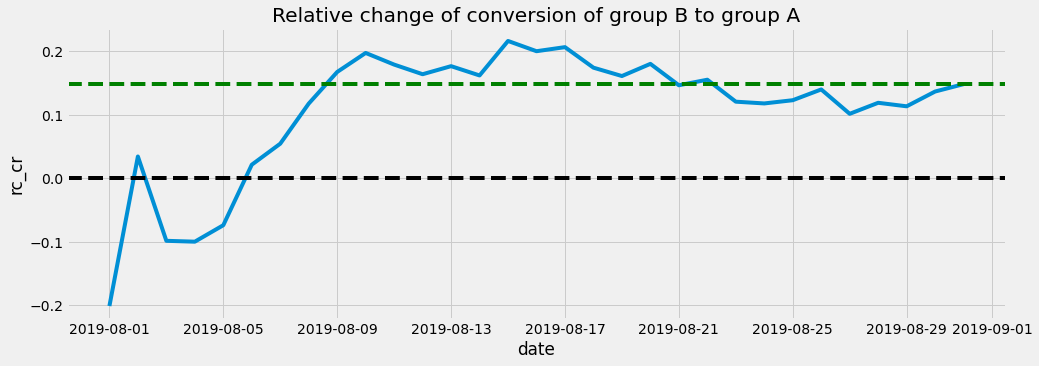

In [29]:
sns.lineplot(data=cumulative_data_horizont, x='date', y='rc_cr', palette='bright', ci=None, estimator='mean')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=float(cumulative_data_horizont.rc_cr[-1:]), color='green', linestyle='--') 
plt.title('Relative change of conversion of group B to group A')
plt.show()

Конверсия группы B в первые дни эксперимента вырвавшись вперед на некоторое время просела относительно группы A. Но дальше - примерно после 10.08 она всегда превышала группу A примерно на 15% <a class="anchor" id="step_5"></a> [обратно](#step_10)

### 3.06. Точечный график количества заказов по пользователям.  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.06"></a>

Начиная с этого раздела приступим к анализу выбросов в искажающих чистоту нашего эксперимента.  
Сперва оценим количество заказов, совершенных клиентами на предмет нестандартных значений

In [30]:
# Создадим датафрейм, в котором будет лишь информация о клиенте и количество созданых им заказов
orders_by_users = orders.groupby('visitorid', as_index=False).agg({'transactionid':pd.Series.nunique})
orders_by_users.columns = ['visitorid', 'orders']
orders_by_users['orders'].describe().T

count   996.00
mean      1.13
std       0.72
min       1.00
25%       1.00
50%       1.00
75%       1.00
max      11.00
Name: orders, dtype: float64

Судя по всему клиенты чаще всего совершают 1 заказ - не менее 75%, но бывает что и 11. Проверим эти данные гистограммой.

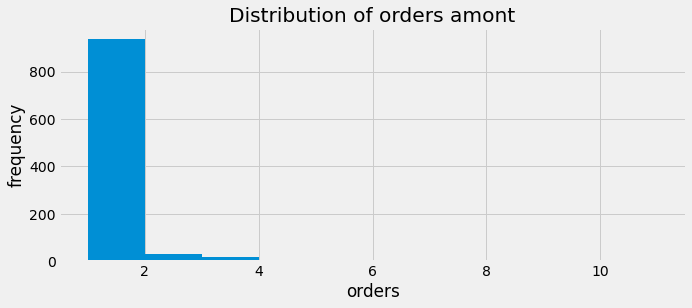

In [31]:
plt.figure(figsize=(10,4))
plt.hist(orders_by_users['orders'])
plt.title('Distribution of orders amont')
plt.xlabel('orders')
plt.ylabel('frequency')
plt.show()

Все верно, практически многие делают по 1 заказу, **но все же не все**. Ессть и 2 и 3 заказа, и даже 11.  
Рассмотрим данные о количестве заказов с иной стороны. Постоим диаграмму рассеяния где по оси x будет порядковый номер клиента, а по оси y - сколько он совершил заказов

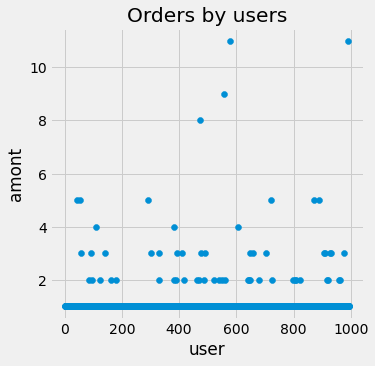

In [32]:
# Присвоим порядковый номер каждому из клиентов
n_user = pd.Series(range(0,orders_by_users.shape[0]))
plt.figure(figsize=(5,5))
plt.scatter(n_user, orders_by_users['orders'])
plt.title('Orders by users')
plt.xlabel('user')
plt.ylabel('amont')
plt.show()

На таком графике более наглядно распределение клиентов по количеству заказов. 
* Приктически все по 1 заказу, 
* чуть меньше по 2 заказа,
* еще меньше по 3 заказа, 
* и т.д. вплоть до 11 заказов, которые сделали 2 человека.  


Очевидно что большинство пользователей делают по 1-2 заказа, но точно определить значение в качестве границы нам помогут перцентили.

### 3.07. 95-й и 99-й перцентили количества заказов на пользователя.  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.07"></a>

Процентили помогут разбить наших клиентов по количеству заказов на 100 частей. В текущем контексте нас интересует количество заказов в 95 и 99 перцентилях

In [33]:
orders_pp = np.percentile(orders_by_users['orders'], [95, 99])
print(f'Как видим не более 1% клиентов сделали {orders_pp[1]:.0f} \
и более заказов, и не более 5% клиентов сделали свыше {orders_pp[0]:.0f} заказов')

Как видим не более 1% клиентов сделали 4 и более заказов, и не более 5% клиентов сделали свыше 2 заказов


Далее в процессе анализа отбросим всех клиентов совершивших более 2 заказов

### 3.08. Точечный график стоимостей заказов.  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.08"></a>

Как и в случае с количеством заказов на клиента определим какие в принципе заказы у нас встречаются

In [34]:
# Создадим датафрейм, в котором будет лишь информация о заказе и количество созданых им заказов
revenue_by_orders = orders.groupby('transactionid', as_index=False).agg({'revenue':'sum'})
revenue_by_orders['revenue'].describe().T

count      1127.00
mean       8247.42
std       40144.90
min          50.00
25%        1210.00
50%        2970.00
75%        8245.00
max     1294500.00
Name: revenue, dtype: float64

Посмотрим на распределение стоимостей заказов на гистограмме

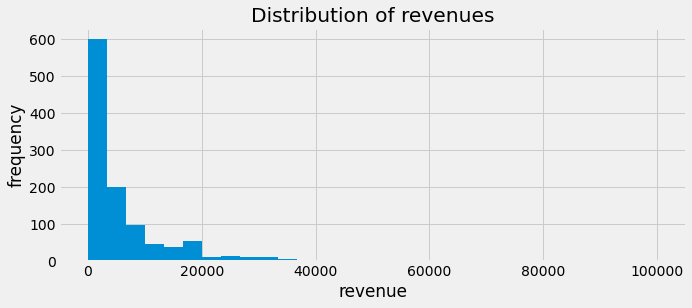

In [35]:
plt.figure(figsize=(10,4))
plt.hist(revenue_by_orders['revenue'], bins=30, range=(0, 100000))
plt.title('Distribution of revenues')
plt.xlabel('revenue')
plt.ylabel('frequency')
plt.show()

Явно видно, что наиболее частые заказы около 1000-1500р., но есть и дорогущие около 1.2 млн. Проверим как стоимости заказов распределились на точечной диагремме

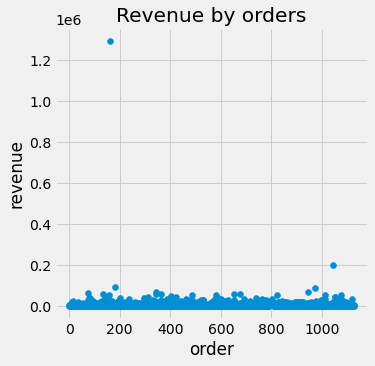

In [36]:
# Присвоим порядковый номер каждому из заказов
n_orders = pd.Series(range(0,revenue_by_orders.shape[0]))
plt.figure(figsize=(5,5))
plt.scatter(n_orders, revenue_by_orders['revenue'])
plt.title('Revenue by orders')
plt.xlabel('order')
plt.ylabel('revenue')
plt.show()

Выводы согласуются с предыдущими. 
* В основном заказывают на пару тысяч р. 
* Несколько заказов на 100-200 тысяч р.
* Один на 200 тысяч р. или около того
* И один на 1.2 млн р. (скорее всего тот самый заказ, который вывел группу B сильно вперед в начале  проекта)

### 3.09. 95-й и 99-й перцентили стоимости заказов.
[к оглавлению](#step_0)
<a class="anchor" id="step_3.09"></a>

In [37]:
orders_value_pp = np.percentile(revenue_by_orders['revenue'], [95, 99])
print(f'Как видим не более 1% заказов стоят дороже {orders_value_pp[1]:.0f}р.,\
и не более 5% заказов дороже {orders_value_pp[0]:.0f}р.')

Как видим не более 1% заказов стоят дороже 55936р.,и не более 5% заказов дороже 27460р.


Далее отбросим всех клиентвов совершивших заказы дороже 55936р.

### 3.10. Рассчет статистической значимости различий в конверсии между группами по «сырым» данным  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.10"></a>

Сформируем гипотезы:
______________
**H0** разницы в конверсиях между двумя группами нет  
**H1** разница в конверсиях есть

Для проверки гипотезы что конверсии групп A и B не отличаются создадим два массива. Длина кажого из массивов равна числу посещений в каждой из групп. Если посещение завершилось заказом, добавим соответствующее число заказов, несли нет, то **НОЛЬ**

In [38]:
"""Создадим две таблицы для групп A и B, где будут id посетителей и сколько каждый сделал заказов
соответсвенно длиной таблицы будет количество результативных визитов
"""
ordersByUsersA = orders.query('group == "A"').groupby(
    'visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders.query('group == "B"').groupby(
    'visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders'] 

In [39]:
"""Если из количества всех визитов отнять длину предыдущей таблицы, 
получим количество нерезультативных визитов, 
создадим серию из этого количества нулей.
Далее соединим серию из нулей и серию из результативных визитов,
это и будет массив передаваемый в тест Манна-Уитни.
Проделаем эту процедуру для двух групп.
"""
sampleA = pd.concat(
    [ordersByUsersA['orders'], pd.Series(
        0, index=np.arange(cumulative_data_horizont['visitorsA'].iloc[-1] - \
                           len(ordersByUsersA['orders'])), name='orders')])

sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(
        0, index=np.arange(cumulative_data_horizont['visitorsB'].iloc[-1] - \
                           len(ordersByUsersB['orders'])), name='orders')])

In [40]:
alpha = .05

In [41]:
cr_raw = st.mannwhitneyu(sampleA, sampleB)
print('p-значение: {0:.3f}'.format(cr_raw.pvalue))
print()
if (cr_raw.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
print()
print("Относительный +выигрыш/-проигрыш по конверсии группы B против группы A {0:.3%}".format(sampleB.mean()/sampleA.mean()-1)) 

p-значение: 0.007

Отвергаем нулевую гипотезу: разница статистически значима

Относительный +выигрыш/-проигрыш по конверсии группы B против группы A 14.798%


По конверсиям эффект от эксперимента явно есть [обратно](#step_10)
<a class="anchor" id="step_6"></a>

### 3.11. Рассчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.11"></a>

Сформируем гипотезы:
______________
**H0** разницы в среднем чеке между двумя группами нет  
**H1** разница в среднем чеке есть

In [42]:
aov_raw = st.mannwhitneyu(orders.query('group == "A"')['revenue'], 
                          orders.query('group == "B"')['revenue'])
print('p-значение: {0:.3f}'.format(aov_raw.pvalue))
print()
if (aov_raw.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
print()
print("Относительный +выигрыш/-проигрыш по среднему чеку группы B против группы A  {0:.3%}".format(
    orders.query('group == "B"')['revenue'].mean()/orders.query('group == "A"')['revenue'].mean()-1))

p-значение: 0.339

Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительный +выигрыш/-проигрыш по среднему чеку группы B против группы A  30.338%


По среднему чеку вероятность в 34% случайно получить такие различия - довольно высокая. Но такой большой относительный выигыш... Не связанли ли он с чеком в 12000000р? [обратно](#step_10)
<a class="anchor" id="step_9"></a>

### 3.12. Рассчет статистической значимости различий в конверсии между группами по «очищенным» данным  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.12"></a>

Сформируем гипотезы: 
___________  
После удаления клиентов совершивших аномально высокое количество заказов  

**H0** разницы в конверсиях между двумя группами нет   
**H1** разница в конверсиях есть

In [43]:
q_id = 0

In [44]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA.query('orders > @orders_pp[@q_id]')['userId'], 
     ordersByUsersB.query('orders > @orders_pp[@q_id]')['userId']], axis = 0)
usersWithExpensiveOrders = orders.query('revenue > @orders_value_pp[@q_id]')['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, 
                           usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
17      199603092
928     204675465
21      237748145
dtype: int64
(72,)


In [45]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],\
     pd.Series(0, index=np.arange(
        cumulative_data_horizont['visitorsA'].iloc[-1] - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],\
     pd.Series(0, index=np.arange(
        cumulative_data_horizont['visitorsB'].iloc[-1] - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

In [46]:
cr_filtered = st.mannwhitneyu(
    sampleAFiltered, 
    sampleBFiltered)
print('p-значение: {0:.3f}'.format(cr_filtered.pvalue))
print()
if (cr_filtered.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
print()
print("Относительный +выигрыш/-проигрыш по конверсии группы B против группы A  {0:.3%}".format(
    sampleBFiltered.mean()/\
    sampleAFiltered.mean()-1)) 

p-значение: 0.007

Отвергаем нулевую гипотезу: разница статистически значима

Относительный +выигрыш/-проигрыш по конверсии группы B против группы A  17.852%


<a class="anchor" id="step_7"></a> [обратно](#step_10)

### 3.13. Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.13"></a>

Сформируем гипотезы:
______________
После удаления клиентов со сверхдорогими заказами

**H0** разницы в среднем чеке между двумя группами нет  
**H1** разница в среднем чеке есть

In [47]:
aov_filtered = st.mannwhitneyu(
    orders.query('group == "A" and visitorid not in @abnormalUsers')['revenue'], 
    orders.query('group == "B" and visitorid not in @abnormalUsers')['revenue'])
print('p-значение: {0:.3f}'.format(aov_filtered.pvalue))
print()
if (aov_filtered.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
print()
print("Относительный +выигрыш/-проигрыш по среднему чеку группы B против группы A  {0:.3%}".format(
    orders.query('group == "A" and visitorid not in @abnormalUsers')['revenue'].mean()/\
    orders.query('group == "B" and visitorid not in @abnormalUsers')['revenue'].mean()-1))

p-значение: 0.316

Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительный +выигрыш/-проигрыш по среднему чеку группы B против группы A  4.699%


### 3.14. Решение по результатам теста.
[к оглавлению](#step_0)
<a class="anchor" id="step_3.14"></a>

### В результате теста:   
<a class="anchor" id="step_10"></a>
* Обнаружилось статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Cтатистически значимого различия по среднему чеку между группами нет. Не обнаружилось оно и после удаления аномалийзначений.
* Согласно [графику](#step_5) конверсия группы B лучше чем группы A зафиксировались на уровне [13%](#step_6)
* После очистки данных от выбросов конверсия группы B улучшилась и зафиксировались на уровне [17%](#step_7)
* [График](#step_8) различия среднего чека колеблется: очень сильно повлиял выбров в 1200000р. На данных этого графика определённые выводы нельзя.
* Согласно статистическому анализу по сырым данных гипотезу об отсутсвии изменений в среденм чеке отклонить не удалось. Причем относительный выигрыш группы B против группы A составил [25%](#step_9)
* После удаления выбросов относительный выигрыш по чеку приобрел адекватные 4%
___________
**В результате изложенного, тест можно признать удавшимся и состоявшимся**  
Клиенты стали покупать чаще - выручка растет, но тратят столько же. Самое время поэкспериментировать как бы заставить клиента больше платить, не снижая количество заказов